In [3]:
!python --version

Python 3.11.11


In [4]:
import torch
torch.__version__

'2.6.0+cu124'

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
cd /content/drive/MyDrive

/content/drive/MyDrive


In [7]:
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

In [8]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device # select gpu from edit -> notebook settings ->gpu

'cuda'

In [9]:
# Setup directory paths to train and test images
train_dir = 'AI_demos/custom_dataset/train'
test_dir = 'AI_demos/custom_dataset/test'

In [10]:
#  Create Datasets and DataLoaders

import os

from torchvision import datasets, transforms
from torch.utils.data import DataLoader

NUM_WORKERS = os.cpu_count()

def create_dataloaders(
    train_dir: str,
    test_dir: str,
    transform: transforms.Compose,
    batch_size: int,
    num_workers: int=NUM_WORKERS
):

  # Use ImageFolder to create dataset(s)
  train_data = datasets.ImageFolder(train_dir, transform=transform)
  test_data = datasets.ImageFolder(test_dir, transform=transform)

  # Get class names
  class_names = train_data.classes

  # Turn images into data loaders
  train_dataloader = DataLoader(
      train_data,
      batch_size=batch_size,
      shuffle=True,
      num_workers=num_workers,
      pin_memory=True,
  )
  test_dataloader = DataLoader(
      test_data,
      batch_size=batch_size,
      shuffle=False,
      num_workers=num_workers,
      pin_memory=True,
  )

  return train_dataloader, test_dataloader, class_names

In [11]:
# Create image size
IMG_SIZE = 224

# Create transform pipeline manually
manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])
print(f"Manually created transforms: {manual_transforms}")

Manually created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)


In [12]:
# Set the batch size
BATCH_SIZE = 32

# Create data loaders
train_dataloader, test_dataloader, class_names = create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transforms,
    batch_size=BATCH_SIZE
)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7b814ef86110>,
 ['benign', 'malignant'])

Displaying image: malignant (270).png
Label: malignant
Image shape: torch.Size([3, 224, 224])


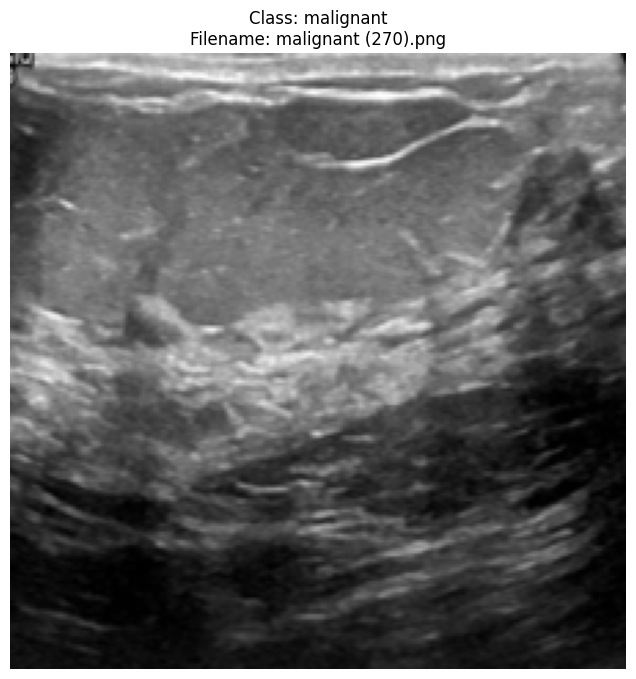


Dataset sizes:
Training set: 705 images
Test set: 173 images

Training set class distribution:
Benign: 350 images
Malignant: 355 images


In [13]:
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import os
import torch
from torchvision import transforms
import matplotlib.pyplot as plt

class BreastCancerDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        self.classes = ['benign', 'malignant']

        # Get all image paths and their filenames
        self.image_paths = []
        self.labels = []
        self.filenames = []

        for class_idx, class_name in enumerate(self.classes):
            class_path = os.path.join(data_dir, class_name)
            for filename in os.listdir(class_path):
                if filename.endswith(('.jpg', '.png', '.jpeg')):
                    self.image_paths.append(os.path.join(class_path, filename))
                    self.labels.append(class_idx)
                    self.filenames.append(filename)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert('RGB')
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label, self.filenames[idx]

# Define transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Create datasets for train and test
train_dataset = BreastCancerDataset(data_dir='AI_demos/custom_dataset/train', transform=transform)
test_dataset = BreastCancerDataset(data_dir='AI_demos/custom_dataset/test', transform=transform)

# Create dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Visualize an image from training set
image_batch, label_batch, filename_batch = next(iter(train_dataloader))

# Get first image details
image = image_batch[0]
label = label_batch[0]
filename = filename_batch[0]

print(f"Displaying image: {filename}")
print(f"Label: {'benign' if label == 0 else 'malignant'}")
print(f"Image shape: {image.shape}")

plt.figure(figsize=(8, 8))
plt.imshow(image.permute(1, 2, 0))
plt.title(f"Class: {'benign' if label == 0 else 'malignant'}\nFilename: {filename}")
plt.axis(False)
plt.show()

# Print dataset sizes
print(f"\nDataset sizes:")
print(f"Training set: {len(train_dataset)} images")
print(f"Test set: {len(test_dataset)} images")

# Print class distribution in training set
train_labels = [label for _, label, _ in train_dataset]
benign_count = sum(1 for label in train_labels if label == 0)
malignant_count = sum(1 for label in train_labels if label == 1)

print(f"\nTraining set class distribution:")
print(f"Benign: {benign_count} images")
print(f"Malignant: {malignant_count} images")

In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, models
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
from torch.utils.data import DataLoader
import os
from PIL import Image
import timm
import cv2

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [15]:
# 2. Enhanced Dataset with Advanced Medical Image Preprocessing
class BreastCancerDataset(torch.utils.data.Dataset):
    def __init__(self, data_dir, transform=None, apply_preprocessing=True):
        self.data_dir = data_dir
        self.transform = transform
        self.classes = ['benign', 'malignant']
        self.apply_preprocessing = apply_preprocessing

        # Get all image paths and their filenames
        self.image_paths = []
        self.labels = []
        self.filenames = []

        for class_idx, class_name in enumerate(self.classes):
            class_path = os.path.join(data_dir, class_name)
            for filename in os.listdir(class_path):
                if filename.endswith(('.jpg', '.png', '.jpeg')):
                    self.image_paths.append(os.path.join(class_path, filename))
                    self.labels.append(class_idx)
                    self.filenames.append(filename)

    def __len__(self):
        return len(self.image_paths)

    def apply_advanced_preprocessing(self, img):
        # Convert to numpy for OpenCV processing
        np_img = np.array(img)

        # Convert to LAB color space
        lab = cv2.cvtColor(np_img, cv2.COLOR_RGB2LAB)

        # Apply CLAHE to L channel with stronger parameters
        clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
        lab[:,:,0] = clahe.apply(lab[:,:,0])

        # Convert back to RGB
        enhanced = cv2.cvtColor(lab, cv2.COLOR_LAB2RGB)

        # Apply bilateral filter for noise reduction while preserving edges
        enhanced = cv2.bilateralFilter(enhanced, 9, 75, 75)

        # Apply unsharp masking for edge enhancement
        gaussian = cv2.GaussianBlur(enhanced, (0, 0), 3.0)
        enhanced = cv2.addWeighted(enhanced, 1.5, gaussian, -0.5, 0)

        return Image.fromarray(enhanced)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert('RGB')
        label = self.labels[idx]

        # Apply advanced preprocessing for better feature visibility
        if self.apply_preprocessing:
            try:
                image = self.apply_advanced_preprocessing(image)
            except:
                pass  # If enhancement fails, use original image

        if self.transform:
            image = self.transform(image)

        return image, label, self.filenames[idx]

In [16]:
# 3. Enhanced Medical Imaging Specific Transforms
def get_transforms(train=True):
    """Enhanced specialized transforms for medical imaging"""
    if train:
        return transforms.Compose([
            # Enhanced standard transforms
            transforms.RandomResizedCrop(224, scale=(0.7, 1.0)),  # Wider scale variation
            transforms.RandomHorizontalFlip(),
            transforms.RandomVerticalFlip(),  # Medical images don't have fixed orientation
            transforms.RandomRotation(90),    # More aggressive rotation
            transforms.GaussianBlur(kernel_size=5, sigma=(0.1, 2.0)),  # Simulate focus variations
            transforms.ColorJitter(brightness=0.3, contrast=0.4, saturation=0.2, hue=0.1),  # More aggressive

            # Convert to tensor (must be before tensor-based transforms)
            transforms.ToTensor(),

            # Tensor-based transforms
            transforms.RandomErasing(p=0.4, scale=(0.02, 0.25)),  # More aggressive erasing
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
    else:
        return transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

In [17]:
# 4. Advanced Ensemble Architecture with ViT and CNN
class ViTCNNEnsemble(nn.Module):
    def __init__(self, num_classes=2):
        super(ViTCNNEnsemble, self).__init__()

        # ViT branch - Use a stronger variant
        self.vit = timm.create_model(
            'vit_base_patch16_224_dino',  # Stronger ViT model
            pretrained=True,
            num_classes=0  # Get feature vector only
        )

        # CNN branch - Use a strong CNN architecture
        self.cnn = timm.create_model(
            'resnet50d',  # Stronger CNN backbone
            pretrained=True,
            num_classes=0  # Get feature vector only
        )

        # Hidden dimension sizes
        self.vit_dim = self.vit.embed_dim  # Usually 768 for vit_base
        self.cnn_dim = 2048  # ResNet50 feature dim

        # Add Stochastic Depth (helps with regularization)
        self.vit.drop_path_rate = 0.2

        # Feature attention module
        self.vit_attention = nn.Sequential(
            nn.Linear(self.vit_dim, self.vit_dim),
            nn.LayerNorm(self.vit_dim),
            nn.GELU(),
            nn.Linear(self.vit_dim, self.vit_dim),
            nn.Sigmoid()
        )

        self.cnn_attention = nn.Sequential(
            nn.Linear(self.cnn_dim, self.cnn_dim),
            nn.LayerNorm(self.cnn_dim),
            nn.GELU(),
            nn.Linear(self.cnn_dim, self.cnn_dim),
            nn.Sigmoid()
        )

        # Feature fusion module
        self.fusion = nn.Sequential(
            nn.Linear(self.vit_dim + self.cnn_dim, 1024),
            nn.LayerNorm(1024),
            nn.GELU(),
            nn.Dropout(0.4)
        )

        # Classification head with strong regularization
        self.classifier = nn.Sequential(
            nn.Linear(1024, 512),
            nn.LayerNorm(512),  # Better normalization
            nn.GELU(),  # GELU often works better than ReLU with transformers
            nn.Dropout(0.3),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        # Extract features from both branches
        vit_features = self.vit(x)
        cnn_features = self.cnn(x)

        # Apply attention to both feature sets
        vit_attention = self.vit_attention(vit_features)
        cnn_attention = self.cnn_attention(cnn_features)

        # Apply attention mechanism
        vit_features = vit_features * vit_attention
        cnn_features = cnn_features * cnn_attention

        # Concatenate features
        combined_features = torch.cat([vit_features, cnn_features], dim=1)

        # Apply fusion and classification
        fused = self.fusion(combined_features)
        out = self.classifier(fused)

        return out

In [18]:
# 5. Implement Mixup Data Augmentation
def mixup_data(x, y, alpha=0.2):
    '''Returns mixed inputs and targets'''
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1

    batch_size = x.size()[0]
    index = torch.randperm(batch_size).to(device)

    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

In [19]:
# 6. Create dataloaders with balanced sampling
def create_dataloaders(batch_size=16):
    """Create dataloaders with class-balanced sampling"""
    # Create datasets with appropriate transforms
    train_dataset = BreastCancerDataset(
        data_dir='AI_demos/custom_dataset/train',
        transform=get_transforms(train=True),
        apply_preprocessing=True  # Apply advanced preprocessing
    )
    test_dataset = BreastCancerDataset(
        data_dir='AI_demos/custom_dataset/test',
        transform=get_transforms(train=False),
        apply_preprocessing=True  # Apply same preprocessing to test
    )

    # Calculate class weights for weighted sampling
    train_labels = torch.tensor([label for _, label, _ in train_dataset])
    class_counts = torch.bincount(train_labels)
    total_samples = sum(class_counts)

    # Calculate inverse weights for more aggressive balancing
    inverse_weights = total_samples / (class_counts * len(class_counts))
    sample_weights = inverse_weights[train_labels]

    # Create sampler for balanced training
    from torch.utils.data import WeightedRandomSampler
    sampler = WeightedRandomSampler(
        weights=sample_weights,
        num_samples=len(train_dataset),
        replacement=True
    )

    # Create dataloaders
    train_dataloader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        sampler=sampler,
        num_workers=os.cpu_count() or 2,
        pin_memory=True
    )

    test_dataloader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=os.cpu_count() or 2,
        pin_memory=True
    )

    # Get class names
    class_names = train_dataset.classes

    return train_dataloader, test_dataloader, class_names

In [20]:
def get_optimizer_grouped_parameters(model, weight_decay=0.05):
    # Track which parameters have been assigned to prevent duplicates
    assigned_params = set()
    optimizer_grouped_parameters = []

    # Define parameter groups with a function to ensure no duplicates
    def add_params_to_group(params_list, weight_decay_value, lr_multiplier):
        filtered_params = []
        for param in params_list:
            # Use id(param) to uniquely identify each parameter
            param_id = id(param)
            if param_id not in assigned_params:
                filtered_params.append(param)
                assigned_params.add(param_id)

        if filtered_params:  # Only add group if it has parameters
            optimizer_grouped_parameters.append({
                "params": filtered_params,
                "weight_decay": weight_decay_value,
                "lr_mult": lr_multiplier
            })

    # No decay for biases and LayerNorm params
    no_decay = ["bias", "LayerNorm.weight"]

    # Group parameters by component and whether they should have weight decay
    vit_params_decay = [p for n, p in model.named_parameters()
                        if not any(nd in n for nd in no_decay) and "vit" in n]
    vit_params_no_decay = [p for n, p in model.named_parameters()
                           if any(nd in n for nd in no_decay) and "vit" in n]

    cnn_params_decay = [p for n, p in model.named_parameters()
                        if not any(nd in n for nd in no_decay) and "cnn" in n]
    cnn_params_no_decay = [p for n, p in model.named_parameters()
                           if any(nd in n for nd in no_decay) and "cnn" in n]

    attention_params_decay = [p for n, p in model.named_parameters()
                              if not any(nd in n for nd in no_decay) and "attention" in n]
    attention_params_no_decay = [p for n, p in model.named_parameters()
                                if any(nd in n for nd in no_decay) and "attention" in n]

    fusion_classifier_params_decay = [p for n, p in model.named_parameters()
                                      if not any(nd in n for nd in no_decay) and ("fusion" in n or "classifier" in n)]
    fusion_classifier_params_no_decay = [p for n, p in model.named_parameters()
                                        if any(nd in n for nd in no_decay) and ("fusion" in n or "classifier" in n)]

    # Add parameters to groups in order of priority
    add_params_to_group(vit_params_decay, weight_decay, 0.05)
    add_params_to_group(vit_params_no_decay, 0.0, 0.05)
    add_params_to_group(cnn_params_decay, weight_decay, 0.1)
    add_params_to_group(cnn_params_no_decay, 0.0, 0.1)
    add_params_to_group(attention_params_decay, weight_decay, 0.3)
    add_params_to_group(attention_params_no_decay, 0.0, 0.3)
    add_params_to_group(fusion_classifier_params_decay, weight_decay, 1.0)
    add_params_to_group(fusion_classifier_params_no_decay, 0.0, 1.0)

    return optimizer_grouped_parameters

In [21]:
# 8. Visualization Functions
def plot_training_history(train_losses, train_accs, test_losses, test_accs):
    """Plot training history"""
    plt.figure(figsize=(15, 5))

    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.plot(test_losses, label='Validation Loss')
    plt.title('Loss Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(train_accs, label='Training Accuracy')
    plt.plot(test_accs, label='Validation Accuracy')
    plt.title('Accuracy Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

def plot_prediction_samples(model, test_dataloader, device, class_names):
    """
    Plot sample predictions for each category:
    - True Positives (predicted = malignant, actual = malignant)
    - False Positives (predicted = malignant, actual = benign)
    - True Negatives (predicted = benign, actual = benign)
    - False Negatives (predicted = benign, actual = malignant)
    """
    model.eval()

    # Lists to store images for each category
    true_positives = []  # Predicted malignant, actually malignant
    false_positives = [] # Predicted malignant, actually benign
    true_negatives = []  # Predicted benign, actually benign
    false_negatives = [] # Predicted benign, actually malignant

    # Create dictionary to map classes to indices
    class_to_idx = {name: i for i, name in enumerate(class_names)}

    # Collect samples for each category
    with torch.no_grad():
        for images, labels, filenames in test_dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = outputs.max(1)

            # Process each image in the batch
            for i in range(len(images)):
                # Get prediction and ground truth
                pred = predicted[i].item()
                truth = labels[i].item()

                # Denormalize image for display
                img = images[i].cpu().permute(1, 2, 0).numpy()
                img = (img - img.min()) / (img.max() - img.min())

                # Categorize based on prediction vs. truth
                sample = (img, filenames[i])

                # Malignant is typically index 1, benign is 0
                if pred == class_to_idx['malignant'] and truth == class_to_idx['malignant']:
                    true_positives.append(sample)
                elif pred == class_to_idx['malignant'] and truth == class_to_idx['benign']:
                    false_positives.append(sample)
                elif pred == class_to_idx['benign'] and truth == class_to_idx['benign']:
                    true_negatives.append(sample)
                elif pred == class_to_idx['benign'] and truth == class_to_idx['malignant']:
                    false_negatives.append(sample)

            # Stop once we have enough samples in each category
            if (len(true_positives) >= 3 and len(false_positives) >= 3 and
                len(true_negatives) >= 3 and len(false_negatives) >= 3):
                break

    # Function to display samples from a category
    def display_category(category_samples, title, max_samples=3):
        if not category_samples:
            print(f"No samples found for {title}")
            return

        samples_to_show = min(max_samples, len(category_samples))
        fig, axes = plt.subplots(1, samples_to_show, figsize=(5*samples_to_show, 5))

        # Handle case with only one sample
        if samples_to_show == 1:
            axes = [axes]

        fig.suptitle(title, fontsize=16)

        for i in range(samples_to_show):
            img, filename = category_samples[i]
            axes[i].imshow(img)
            axes[i].set_title(f"File: {filename}")
            axes[i].axis('off')

        plt.tight_layout()
        plt.show()

    # Display samples for each category
    print("\nSample Predictions:")

    display_category(true_positives, "True Positives (Predicted: Malignant, Actual: Malignant)")
    display_category(false_positives, "False Positives (Predicted: Malignant, Actual: Benign)")
    display_category(true_negatives, "True Negatives (Predicted: Benign, Actual: Benign)")
    display_category(false_negatives, "False Negatives (Predicted: Benign, Actual: Malignant)")

    # Print summary counts
    print(f"\nSample counts:")
    print(f"True Positives (correctly identified malignant): {len(true_positives)}")
    print(f"False Positives (benign incorrectly classified as malignant): {len(false_positives)}")
    print(f"True Negatives (correctly identified benign): {len(true_negatives)}")
    print(f"False Negatives (malignant incorrectly classified as benign): {len(false_negatives)}")

def predict_single_image(model, image_path, device, class_names, apply_preprocessing=True):
    """
    Make prediction on a single image using trained model

    Args:
        model: Trained model
        image_path: Path to the image file
        device: Device to run inference on (cuda/cpu)
        class_names: List of class names
        apply_preprocessing: Whether to apply preprocessing
    """
    # Set model to evaluation mode
    model.eval()

    # Load and preprocess the image
    try:
        # Load image
        image = Image.open(image_path).convert('RGB')

        # Apply preprocessing for better feature visibility
        if apply_preprocessing:
            try:
                # Apply advanced preprocessing
                np_img = np.array(image)

                # Convert to LAB color space
                lab = cv2.cvtColor(np_img, cv2.COLOR_RGB2LAB)

                # Apply CLAHE to L channel
                clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
                lab[:,:,0] = clahe.apply(lab[:,:,0])

                # Convert back to RGB
                enhanced = cv2.cvtColor(lab, cv2.COLOR_LAB2RGB)

                # Apply bilateral filter for noise reduction while preserving edges
                enhanced = cv2.bilateralFilter(enhanced, 9, 75, 75)

                # Apply unsharp masking for edge enhancement
                gaussian = cv2.GaussianBlur(enhanced, (0, 0), 3.0)
                enhanced = cv2.addWeighted(enhanced, 1.5, gaussian, -0.5, 0)

                image = Image.fromarray(enhanced)
            except:
                print("Preprocessing failed, using original image")

        # Define transforms for test
        transform = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])

        # Transform image
        image_tensor = transform(image).unsqueeze(0).to(device)  # Add batch dimension

        # Make prediction
        with torch.no_grad():
            output = model(image_tensor)
            probabilities = torch.nn.functional.softmax(output, dim=1)
            confidence, prediction = torch.max(probabilities, 1)

        # Get predicted class name
        predicted_class = class_names[prediction.item()]
        confidence_score = confidence.item() * 100

        # Display image with prediction
        plt.figure(figsize=(8, 8))
        plt.imshow(image)
        plt.title(f'Prediction: {predicted_class}\nConfidence: {confidence_score:.2f}%')
        plt.axis('off')
        plt.show()

        # Print detailed results
        print(f"\nDetailed Results:")
        print(f"Predicted Class: {predicted_class}")
        print(f"Confidence Score: {confidence_score:.2f}%")

        # Print probabilities for all classes
        print("\nClass Probabilities:")
        for i, class_name in enumerate(class_names):
            prob = probabilities[0][i].item() * 100
            print(f"{class_name}: {prob:.2f}%")

    except Exception as e:
        print(f"Error processing image: {str(e)}")

In [22]:
# 9. Test Time Augmentation for higher inference accuracy
def predict_with_tta(model, image_path, device, class_names, num_augments=10):
    """Test-time augmentation for more accurate predictions"""
    model.eval()
    image = Image.open(image_path).convert('RGB')

    # Apply advanced preprocessing
    try:
        # Apply advanced preprocessing
        np_img = np.array(image)

        # Convert to LAB color space
        lab = cv2.cvtColor(np_img, cv2.COLOR_RGB2LAB)

        # Apply CLAHE to L channel
        clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
        lab[:,:,0] = clahe.apply(lab[:,:,0])

        # Convert back to RGB
        enhanced = cv2.cvtColor(lab, cv2.COLOR_LAB2RGB)

        # Apply bilateral filter for noise reduction while preserving edges
        enhanced = cv2.bilateralFilter(enhanced, 9, 75, 75)

        # Apply unsharp masking for edge enhancement
        gaussian = cv2.GaussianBlur(enhanced, (0, 0), 3.0)
        enhanced = cv2.addWeighted(enhanced, 1.5, gaussian, -0.5, 0)

        image = Image.fromarray(enhanced)
    except:
        pass

    # Basic transform for center crop
    base_transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    # Additional augmentations for TTA
    augments = [
        transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
        transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.RandomHorizontalFlip(p=1.0),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
        transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.RandomVerticalFlip(p=1.0),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
        transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.RandomRotation(degrees=(90, 90)),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
        transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.RandomRotation(degrees=(180, 180)),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
        transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.RandomRotation(degrees=(270, 270)),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
        # Add more TTA variations
        transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ColorJitter(brightness=0.2),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
        transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ColorJitter(contrast=0.2),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
        transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.GaussianBlur(kernel_size=5, sigma=0.5),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
        transforms.Compose([
            transforms.Resize(224),  # Different resize strategy
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
    ]

    # Run prediction with multiple augmentations
    predictions = []

    with torch.no_grad():
        # Base prediction
        img_tensor = base_transform(image).unsqueeze(0).to(device)
        outputs = model(img_tensor)
        predictions.append(torch.softmax(outputs, dim=1))

        # Augmented predictions
        for transform in augments:
            img_tensor = transform(image).unsqueeze(0).to(device)
            outputs = model(img_tensor)
            predictions.append(torch.softmax(outputs, dim=1))

    # Average predictions
    avg_preds = torch.mean(torch.cat(predictions, dim=0), dim=0)
    confidence, predicted_class = torch.max(avg_preds, dim=0)

    # Show results
    print(f"\nTTA Prediction Results:")
    print(f"Predicted Class: {class_names[predicted_class.item()]}")
    print(f"Confidence: {confidence.item()*100:.2f}%")

    # Print probabilities for all classes
    print("\nClass Probabilities:")
    for i, class_name in enumerate(class_names):
        prob = avg_preds[i].item() * 100
        print(f"{class_name}: {prob:.2f}%")

    return predicted_class.item(), confidence.item()

In [23]:
def train_model():
    # Hyperparameters
    num_epochs = 60
    batch_size = 8
    base_lr = 0.0002
    weight_decay = 0.05
    mixup_alpha = 0.2
    accumulation_steps = 4

    # Early stopping
    patience = 15
    best_val_loss = float('inf')
    patience_counter = 0

    # Dataloaders
    train_dataloader, test_dataloader, class_names = create_dataloaders(batch_size=batch_size)
    model = ViTCNNEnsemble(num_classes=len(class_names)).to(device)

    # Compute class weights
    train_dataset = train_dataloader.dataset
    train_labels = torch.tensor([label for _, label, _ in train_dataset])
    class_counts = torch.bincount(train_labels)
    total_samples = sum(class_counts)
    inverse_weights = total_samples / (class_counts * len(class_counts))
    class_weights = torch.FloatTensor(inverse_weights).to(device)
    print(f"Class weights for loss function: {class_weights}")

    # Loss, optimizer, scheduler
    loss_fn = nn.CrossEntropyLoss(weight=class_weights)
    param_groups = get_optimizer_grouped_parameters(model, weight_decay=weight_decay)
    optimizer = optim.AdamW([
        {"params": p["params"], "lr": base_lr * p["lr_mult"], "weight_decay": p["weight_decay"]}
        for p in param_groups
    ])
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs, eta_min=1e-6)

    # History
    train_losses, train_accs = [], []
    test_losses, test_accs = [], []
    best_model_state = None
    best_accuracy = 0.0

    print(f"\nStarting training for {num_epochs} epochs...")

    for epoch in range(num_epochs):
        model.train()
        running_loss, correct, total = 0.0, 0, 0
        optimizer.zero_grad()

        for batch_idx, (images, labels, _) in enumerate(train_dataloader):
            images, labels = images.to(device), labels.to(device)

            use_mixup = np.random.random() < 0.5
            if use_mixup:
                images, labels_a, labels_b, lam = mixup_data(images, labels, mixup_alpha)
                outputs = model(images)
                loss = mixup_criterion(loss_fn, outputs, labels_a, labels_b, lam)
            else:
                outputs = model(images)
                loss = loss_fn(outputs, labels)

            loss = loss / accumulation_steps
            loss.backward()

            running_loss += loss.item() * accumulation_steps
            _, predicted = outputs.max(1)

            if use_mixup:
                total += labels_a.size(0)
                correct += (lam * predicted.eq(labels_a).sum().float() +
                            (1 - lam) * predicted.eq(labels_b).sum().float()).item()
            else:
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()

            if (batch_idx + 1) % accumulation_steps == 0 or (batch_idx + 1) == len(train_dataloader):
                optimizer.step()
                optimizer.zero_grad()

            if (batch_idx + 1) % 10 == 0 or (batch_idx + 1) == len(train_dataloader):
                print(f"Epoch [{epoch+1}/{num_epochs}] | Batch [{batch_idx+1}/{len(train_dataloader)}] | "
                      f"Loss: {running_loss/(batch_idx+1):.4f} | "
                      f"Acc: {100.0*correct/total:.2f}%")

        train_loss = running_loss / len(train_dataloader)
        train_acc = 100.0 * correct / total
        train_losses.append(train_loss)
        train_accs.append(train_acc)

        # Validation
        model.eval()
        test_loss, test_correct, test_total = 0.0, 0, 0
        all_preds, all_labels = [], []

        with torch.no_grad():
            for images, labels, _ in test_dataloader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = loss_fn(outputs, labels)

                test_loss += loss.item()
                _, predicted = outputs.max(1)
                test_total += labels.size(0)
                test_correct += predicted.eq(labels).sum().item()

                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        test_loss /= len(test_dataloader)
        test_acc = 100.0 * test_correct / test_total
        test_losses.append(test_loss)
        test_accs.append(test_acc)

        scheduler.step()

        print(f"Epoch [{epoch+1}/{num_epochs}] Summary | "
              f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}% | "
              f"Val Loss: {test_loss:.4f} | Val Acc: {test_acc:.2f}%")

        # Save best model
        if test_acc > best_accuracy:
            best_accuracy = test_acc
            best_model_state = model.state_dict().copy()
            torch.save(model.state_dict(), "best_breast_cancer_model.pth")
            print(f"New best model with accuracy: {best_accuracy:.2f}%")
            patience_counter = 0
        else:
            patience_counter += 1
            print(f"No improvement for {patience_counter} epochs")

        # Early stopping
        if patience_counter >= patience:
            print(f"Early stopping triggered after {epoch+1} epochs")
            break

        # Confusion matrix
        if (epoch + 1) % 5 == 0 or (epoch + 1) == num_epochs:
            cm = confusion_matrix(all_labels, all_preds)
            print("\nConfusion Matrix:")
            print(cm)
            print("\nClassification Report:")
            print(classification_report(all_labels, all_preds, target_names=class_names))

    # Load best model
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
        print(f"Loaded best model with validation accuracy: {best_accuracy:.2f}%")

    # Plot history and evaluate
    plot_training_history(train_losses, train_accs, test_losses, test_accs)
    print("\nFinal Evaluation:")
    evaluate_model(model, test_dataloader, class_names)
    plot_prediction_samples(model, test_dataloader, device, class_names)

    return model, class_names


In [24]:
# 11. Evaluate model on test set
def evaluate_model(model, test_dataloader, class_names):
    """Evaluate model on test set"""
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels, _ in test_dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = outputs.max(1)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Compute confusion matrix
    cm = confusion_matrix(all_labels, all_preds)

    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

    # Print classification report
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=class_names))

    # Calculate and print metrics
    accuracy = 100.0 * np.sum(np.array(all_preds) == np.array(all_labels)) / len(all_labels)
    print(f"Test Accuracy: {accuracy:.2f}%")

    # Calculate sensitivity and specificity
    # Assuming class_names[1] is 'malignant' (positive class)
    malignant_idx = class_names.index('malignant')

    # Convert to binary problem
    y_true = np.array(all_labels) == malignant_idx
    y_pred = np.array(all_preds) == malignant_idx

    # Calculate metrics
    true_pos = np.sum((y_true == True) & (y_pred == True))
    true_neg = np.sum((y_true == False) & (y_pred == False))
    false_pos = np.sum((y_true == False) & (y_pred == True))
    false_neg = np.sum((y_true == True) & (y_pred == False))

    # Sensitivity (Recall)
    sensitivity = true_pos / (true_pos + false_neg) if (true_pos + false_neg) > 0 else 0
    # Specificity
    specificity = true_neg / (true_neg + false_pos) if (true_neg + false_pos) > 0 else 0
    # Precision
    precision = true_pos / (true_pos + false_pos) if (true_pos + false_pos) > 0 else 0
    # F1 Score
    f1 = 2 * (precision * sensitivity) / (precision + sensitivity) if (precision + sensitivity) > 0 else 0

    print(f"\nClinical Metrics:")
    print(f"Sensitivity (Recall): {sensitivity:.4f}")
    print(f"Specificity: {specificity:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"F1 Score: {f1:.4f}")


Starting Breast Cancer Classification Model Training


/usr/local/lib/python3.11/dist-packages/timm/models/_factory.py:126: UserWarning: Mapping deprecated model name vit_base_patch16_224_dino to current vit_base_patch16_224.dino.
  model = create_fn(
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/343M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/103M [00:00<?, ?B/s]

Class weights for loss function: tensor([1.0071, 0.9930], device='cuda:0')

Starting training for 60 epochs...
Epoch [1/60] | Batch [10/89] | Loss: 0.7219 | Acc: 56.43%
Epoch [1/60] | Batch [20/89] | Loss: 0.6727 | Acc: 61.79%
Epoch [1/60] | Batch [30/89] | Loss: 0.6458 | Acc: 64.44%
Epoch [1/60] | Batch [40/89] | Loss: 0.6286 | Acc: 66.59%
Epoch [1/60] | Batch [50/89] | Loss: 0.6119 | Acc: 67.18%
Epoch [1/60] | Batch [60/89] | Loss: 0.6039 | Acc: 67.31%
Epoch [1/60] | Batch [70/89] | Loss: 0.5759 | Acc: 69.07%
Epoch [1/60] | Batch [80/89] | Loss: 0.5548 | Acc: 70.02%
Epoch [1/60] | Batch [89/89] | Loss: 0.5551 | Acc: 70.23%
Epoch [1/60] Summary | Train Loss: 0.5551 | Train Acc: 70.23% | Val Loss: 0.7045 | Val Acc: 69.36%
New best model with accuracy: 69.36%
Epoch [2/60] | Batch [10/89] | Loss: 0.6209 | Acc: 71.55%
Epoch [2/60] | Batch [20/89] | Loss: 0.5026 | Acc: 77.05%
Epoch [2/60] | Batch [30/89] | Loss: 0.4959 | Acc: 76.46%
Epoch [2/60] | Batch [40/89] | Loss: 0.4820 | Acc: 77.99%

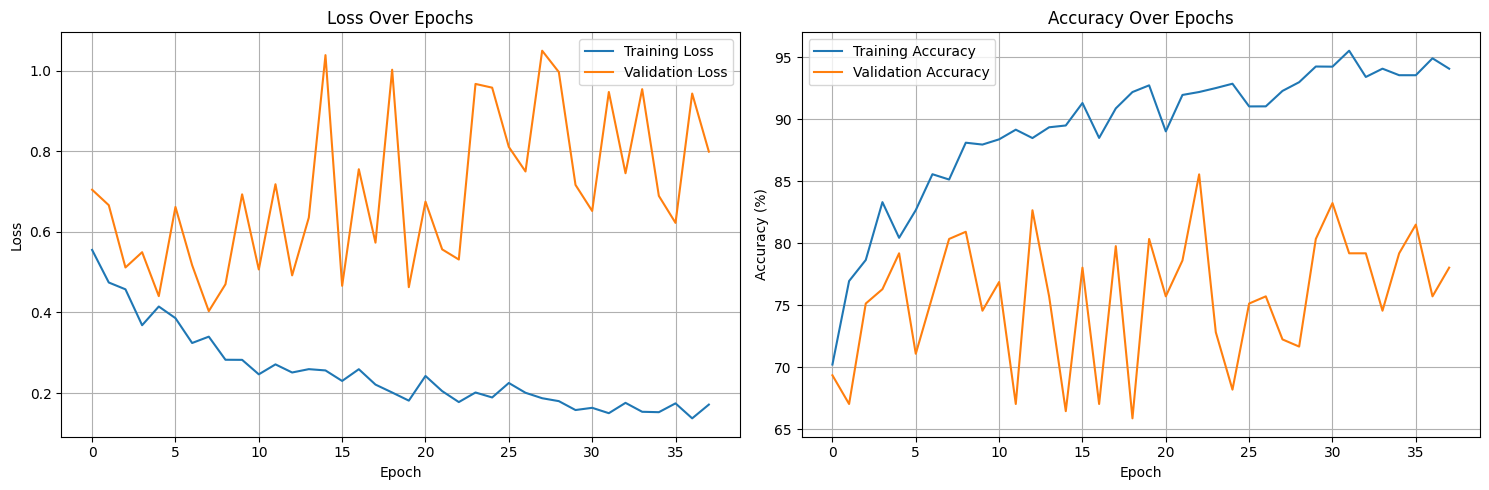


Final Evaluation:


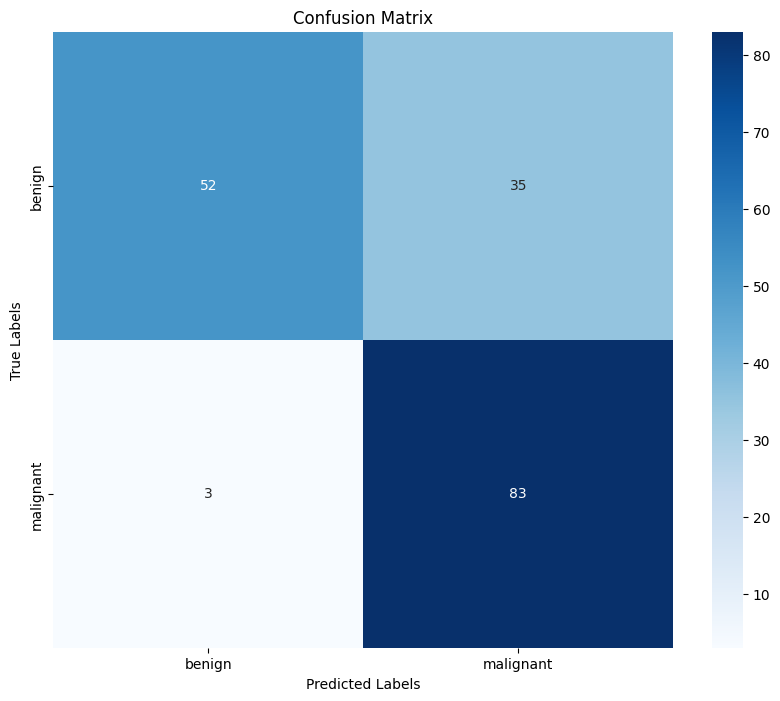


Classification Report:
              precision    recall  f1-score   support

      benign       0.95      0.60      0.73        87
   malignant       0.70      0.97      0.81        86

    accuracy                           0.78       173
   macro avg       0.82      0.78      0.77       173
weighted avg       0.83      0.78      0.77       173

Test Accuracy: 78.03%

Clinical Metrics:
Sensitivity (Recall): 0.9651
Specificity: 0.5977
Precision: 0.7034
F1 Score: 0.8137

Sample Predictions:


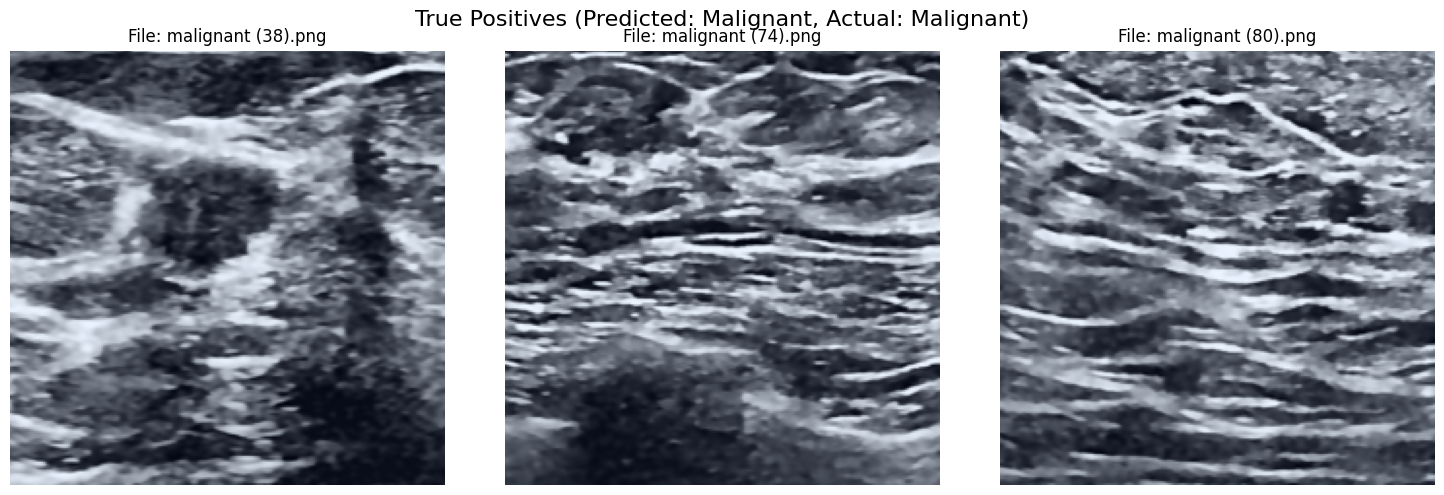

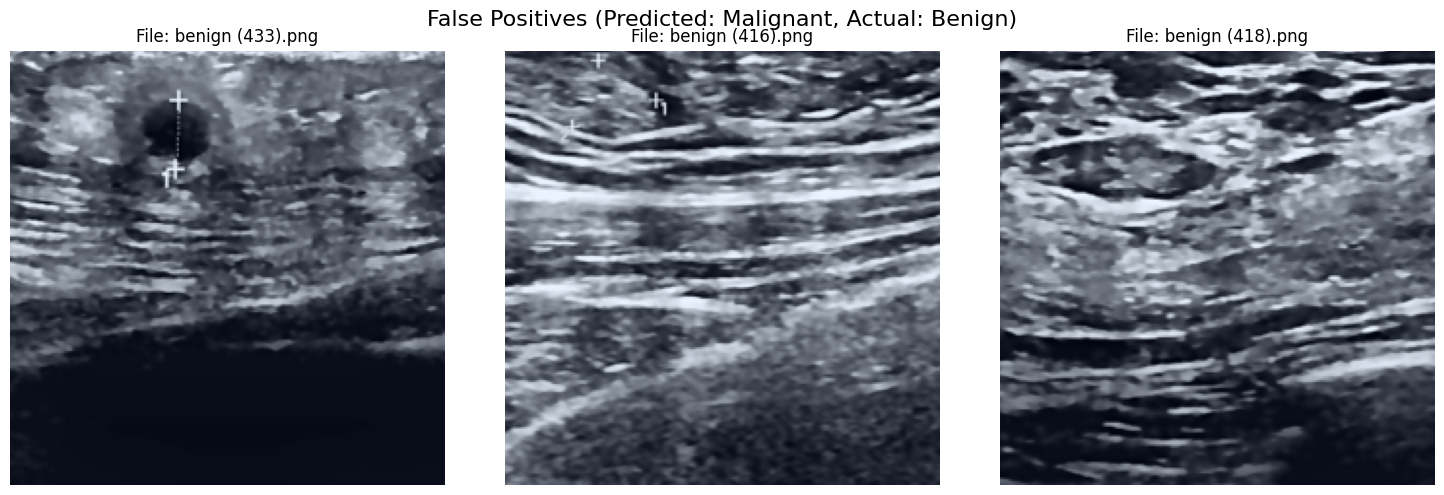

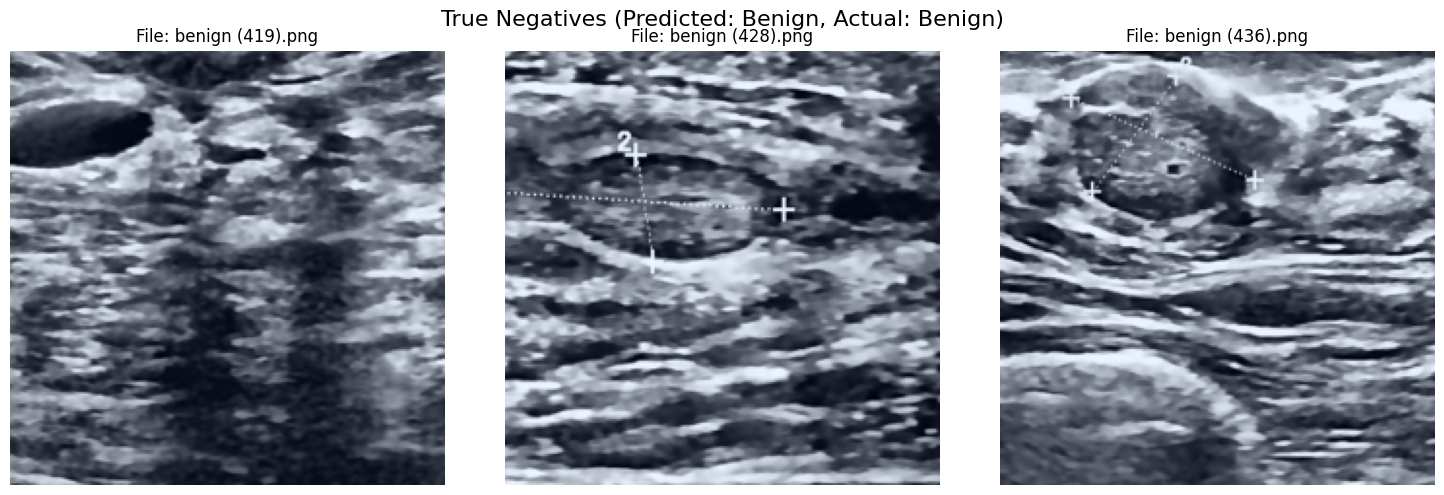

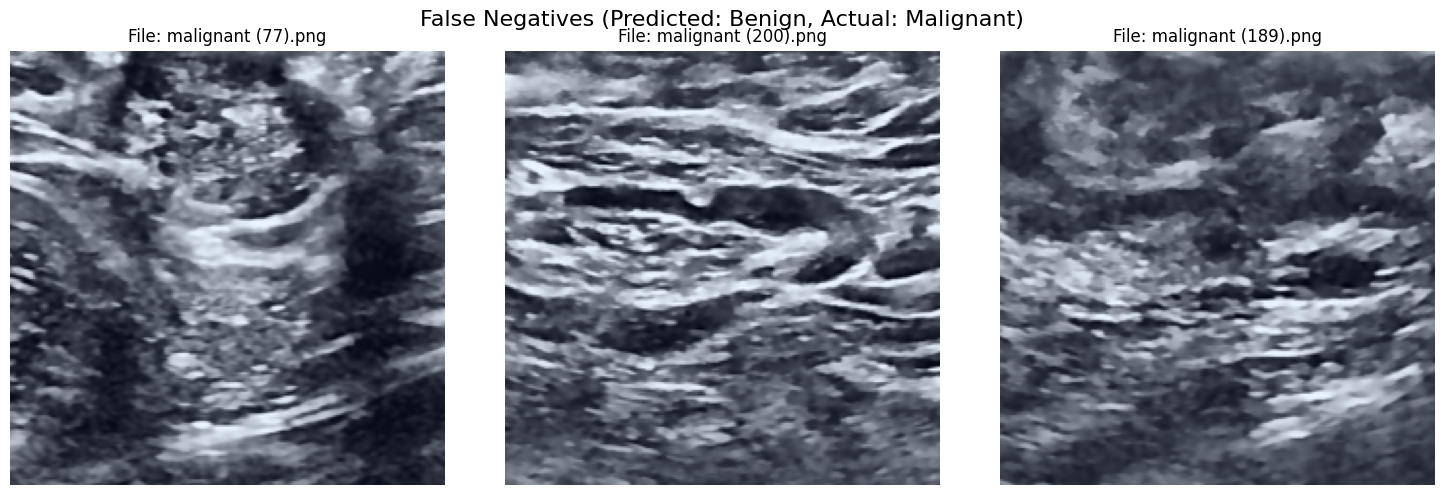


Sample counts:
True Positives (correctly identified malignant): 78
False Positives (benign incorrectly classified as malignant): 35
True Negatives (correctly identified benign): 52
False Negatives (malignant incorrectly classified as benign): 3

Model saved successfully!

Example Prediction on a Single Image:


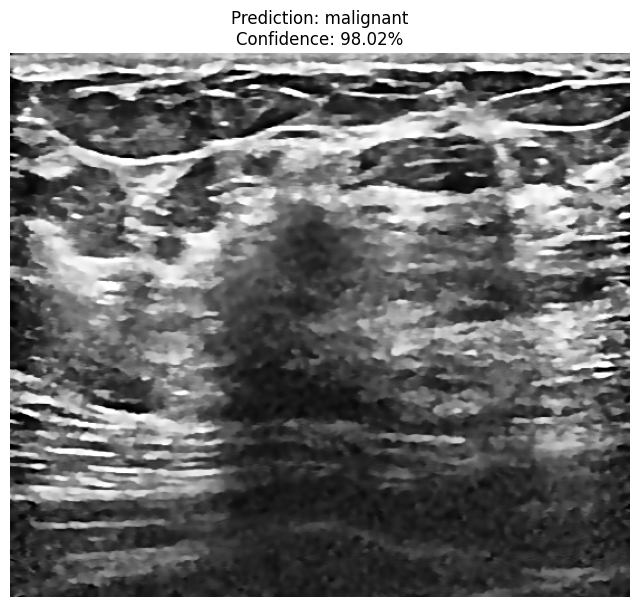


Detailed Results:
Predicted Class: malignant
Confidence Score: 98.02%

Class Probabilities:
benign: 1.98%
malignant: 98.02%

Example Prediction with Test-Time Augmentation:


In [25]:
# 12. Main execution function
def main():
    """Main execution function"""
    print("Starting Breast Cancer Classification Model Training")

    # Training model
    model, class_names = train_model()

    # Save model
    torch.save({
        'model_state_dict': model.state_dict(),
        'class_names': class_names
    }, "breast_cancer_classifier_final.pth")

    print("\nModel saved successfully!")

    # Example: Predict on a single image
    print("\nExample Prediction on a Single Image:")

    image_path = "/content/drive/MyDrive/AI_demos/test.png"
    predict_single_image(model, image_path, device, class_names)

    # Example: Predict with Test-Time Augmentation
    print("\nExample Prediction with Test-Time Augmentation:")
    # predict_with_tta(model, "path/to/your/image.jpg", device, class_names)

if __name__ == "__main__":
    main()